In [ ]:
!pip install meshio
#!pip install torch-geometric torch-scatter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 3.5 MB/s eta 0:00:00


In [ ]:
import torch
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html

!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 79.2 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-gknzl2c5
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-gknzl2c5
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 9b794b600d41802edaad26aac18bff958fc8f642
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-none-any.whl size=1170967 sha256=b21652b9bc692ab7286702097c0a61fd896354b862e13e2886146d57897f479c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ha3gctja/wheels/93/bb/85/bfec4ee59b2563f74ec87cc2c91c6a4d3e40d3dcdec8ee5afe
Successfully built torch-geometric


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import os
import tensorflow as tf
import torch
import meshio
from torch_geometric.data import Data
import zipfile

import random
import pandas as pd
import torch_scatter
import torch.nn as nn
from torch.nn import Linear, Sequential, LayerNorm, ReLU
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.data import DataLoader

import time
import torch.optim as optim
from tqdm import trange
import copy
import matplotlib.pyplot as plt
from typing import List

In [ ]:
def xdmf_to_meshes(xdmf_file_path: str) -> List[meshio.Mesh]:
    """
    Opens an XDMF archive file, and extract a data mesh object for every timestep.

    xdmf_file_path: path to the .xdmf file.
    Returns: list of data mesh objects.
    """

    reader = meshio.xdmf.TimeSeriesReader(xdmf_file_path)
    points, cells = reader.read_points_cells()
    meshes = []

    # Extracting the meshes from the archive
    for i in range(reader.num_steps):
        # Depending on meshio version, the function read_data may return 3 or 4 values.
        try:
            time, point_data, cell_data, _ = reader.read_data(i)
        except ValueError:
            time, point_data, cell_data = reader.read_data(i)
        mesh = meshio.Mesh(points, cells, point_data=point_data, cell_data=cell_data)
        meshes.append(mesh)
    print(f"Loaded {len(meshes)} timesteps from {xdmf_file_path.split('/')[-1]}\n")
    return meshes

In [ ]:
def tetra_to_edges(tetra):
  """Computes mesh edges from tetrahedrons.

  """
  # collect edges from tetra
  edges = tf.concat([tetra[:, 0:2], # 1-2
                     tetra[:, 1:3], # 2-3
                     tetra[:, 2:4], # 3-4
                     tf.stack([tetra[:, 2], tetra[:, 0]], axis=1), # 3-1
                     tf.stack([tetra[:, 3], tetra[:, 0]], axis=1), # 4-1
                     tf.stack([tetra[:, 3], tetra[:, 1]], axis=1)], axis=0) # 4-2
  # those edges are sometimes duplicated (within the mesh) and sometimes
  # single (at the mesh boundary).
  # sort & pack edges as single tf.int64
  receivers = tf.reduce_min(edges, axis=1)
  senders = tf.reduce_max(edges, axis=1)
  packed_edges = tf.bitcast(tf.stack([senders, receivers], axis=1), tf.int64)
  # remove duplicates and unpack
  unique_edges = tf.bitcast(tf.unique(packed_edges)[0], tf.int32)
  senders, receivers = tf.unstack(unique_edges, axis=1)
  # create two-way connectivity
  return (tf.concat([senders, receivers], axis=0),
          tf.concat([receivers, senders], axis=0))

In [ ]:
!gdown 1W90lq3I_5RY-Ff48hjR3QoqBzHFAxOiR

Downloading...
From (original): https://drive.google.com/uc?id=1W90lq3I_5RY-Ff48hjR3QoqBzHFAxOiR
From (redirected): https://drive.google.com/uc?id=1W90lq3I_5RY-Ff48hjR3QoqBzHFAxOiR&confirm=t&uuid=983d291c-15be-407a-bd3e-2eaaf9a24313
To: /content/IDSC2025_AnXplore03.zip
100% 1.45G/1.45G [00:12<00:00, 113MB/s]


In [ ]:
# Read files
with zipfile.ZipFile('/content/IDSC2025_AnXplore03.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/')

In [ ]:
xdmf_files = [f for f in os.listdir('/content/data/4Students_AnXplore03/') if f[-1] == 'f']

In [ ]:
data_list = []
dt = 0.01
image_count = 0
for f in xdmf_files:
    if image_count > 90:
        break
    image_count += 1
    data = xdmf_to_meshes(f"/content/data/4Students_AnXplore03/{f}")
    node_type = np.zeros((len(data[0].point_data['Vitesse']), 9))
    #print(np.linalg.norm(data[0].point_data['Vitesse'], axis = 1).shape )
    node_type[np.linalg.norm(data[0].point_data['Vitesse'], axis=1) < 10e-10] = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0])
    node_type[np.linalg.norm(data[0].point_data['Vitesse'], axis=1) > 10e-10] = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0])
    node_type = torch.tensor(node_type)
    for ts in range(79):

        # Note that it's faster to convert to numpy then to torch than to
        # import to torch from h5 format directly
        momentum = torch.tensor(np.array(data[ts].point_data['Vitesse']))
        # node_type = torch.tensor(np.array(data[ts].point_data['Vitesse'].shape[0]*[[1, 0, 0, 0, 0, 0, 0, 0, 0]]))
        x = torch.cat((momentum, node_type),dim=-1).type(torch.float)

        # Get edge indices in COO format
        edges = tetra_to_edges(tf.convert_to_tensor(data[ts].cells_dict['tetra'].tolist()))

        edge_index = torch.cat( (torch.tensor(edges[0].numpy()).unsqueeze(0),
                        torch.tensor(edges[1].numpy()).unsqueeze(0)), dim=0).type(torch.long)

        # Get edge features
        u_i = torch.tensor(np.array(data[ts].points))[edge_index[0]]
        u_j = torch.tensor(np.array(data[ts].points))[edge_index[1]]
        u_ij = u_i-u_j
        u_ij_norm = torch.norm(u_ij, p=2, dim=1, keepdim=True)
        edge_attr = torch.cat((u_ij, u_ij_norm), dim=-1).type(torch.float)

        # Node outputs, for training (velocity)
        v_t = torch.tensor(np.array(data[ts].point_data['Vitesse']))
        v_tp1=torch.tensor(np.array(data[ts+1].point_data['Vitesse']))
        y=((v_tp1-v_t)/dt).type(torch.float)

        # Node outputs, for testing integrator (pressure)
        p = torch.tensor(np.array(data[ts].point_data['Pression']))

        # Data needed for visualization code
        cells = torch.tensor(data[ts].cells_dict['tetra'])
        mesh_pos=torch.tensor(np.array(data[ts].points))

        data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr,y=y,p=p,
                                cells=cells,mesh_pos=mesh_pos))

print("Done collecting data!")

# os.path.join(data_folder + '/test.h5')
# torch.save(data_list, os.path.join(data_folder + '/test_processed_set.pt'))
# torch.save(data_list,'./'+dataset_dir+'/test_processed_set.pt')

Loaded 80 timesteps from AllFields_Resultats_MESH_192.xdmf

Loaded 80 timesteps from AllFields_Resultats_MESH_183.xdmf

Loaded 80 timesteps from AllFields_Resultats_MESH_182-1.xdmf

Loaded 80 timesteps from AllFields_Resultats_MESH_117.xdmf

Loaded 80 timesteps from AllFields_Resultats_MESH_195.xdmf

Loaded 80 timesteps from AllFields_Resultats_MESH_152.xdmf

Loaded 80 timesteps from AllFields_Resultats_MESH_159.xdmf

Loaded 80 timesteps from AllFields_Resultats_MESH_205.xdmf

Loaded 80 timesteps from AllFields_Resultats_MESH_153.xdmf

Loaded 80 timesteps from AllFields_Resultats_MESH_211.xdmf

Loaded 80 timesteps from AllFields_Resultats_MESH_158.xdmf

Loaded 80 timesteps from AllFields_Resultats_MESH_180.xdmf

Loaded 80 timesteps from AllFields_Resultats_MESH_186-1.xdmf

Loaded 80 timesteps from AllFields_Resultats_MESH_191.xdmf

Loaded 80 timesteps from AllFields_Resultats_MESH_157.xdmf

Loaded 80 timesteps from AllFields_Resultats_MESH_1.xdmf

Loaded 80 timesteps from AllFields_Res

In [ ]:
data_list2 = data_list[:5]

### Normalization

In [ ]:
def normalize(to_normalize,mean_vec,std_vec):
    return (to_normalize-mean_vec)/std_vec

def unnormalize(to_unnormalize,mean_vec,std_vec):
    return to_unnormalize*std_vec+mean_vec

def get_stats(data_list):
    '''
    Method for normalizing processed datasets. Given  the processed data_list,
    calculates the mean and standard deviation for the node features, edge features,
    and node outputs, and normalizes these using the calculated statistics.
    '''

    #mean and std of the node features are calculated
    mean_vec_x=torch.zeros(data_list[0].x.shape[1:])
    std_vec_x=torch.zeros(data_list[0].x.shape[1:])

    #mean and std of the edge features are calculated
    mean_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])
    std_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])

    #mean and std of the output parameters are calculated
    mean_vec_y=torch.zeros(data_list[0].y.shape[1:])
    std_vec_y=torch.zeros(data_list[0].y.shape[1:])

    #Define the maximum number of accumulations to perform such that we do
    #not encounter memory issues
    max_accumulations = 10**6

    #Define a very small value for normalizing to
    eps=torch.tensor(1e-8)

    #Define counters used in normalization
    num_accs_x = 0
    num_accs_edge=0
    num_accs_y=0

    #Iterate through the data in the list to accumulate statistics
    for dp in data_list:

        #Add to the
        mean_vec_x+=torch.sum(dp.x,dim=0)
        std_vec_x+=torch.sum(dp.x**2,dim=0)
        num_accs_x+=dp.x.shape[0]

        mean_vec_edge+=torch.sum(dp.edge_attr,dim=0)
        std_vec_edge+=torch.sum(dp.edge_attr**2,dim=0)
        num_accs_edge+=dp.edge_attr.shape[0]

        mean_vec_y+=torch.sum(dp.y,dim=0)
        std_vec_y+=torch.sum(dp.y**2,dim=0)
        num_accs_y+=dp.y.shape[0]

        if(num_accs_x>max_accumulations or num_accs_edge>max_accumulations or num_accs_y>max_accumulations):
            break

    mean_vec_x = mean_vec_x/num_accs_x
    std_vec_x = torch.maximum(torch.sqrt(std_vec_x/num_accs_x - mean_vec_x**2),eps)

    mean_vec_edge = mean_vec_edge/num_accs_edge
    std_vec_edge = torch.maximum(torch.sqrt(std_vec_edge/num_accs_edge - mean_vec_edge**2),eps)

    mean_vec_y = mean_vec_y/num_accs_y
    std_vec_y = torch.maximum(torch.sqrt(std_vec_y/num_accs_y - mean_vec_y**2),eps)

    mean_std_list=[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y]

    return mean_std_list

### Model

In [ ]:
class ProcessorLayer(MessagePassing):
    def __init__(self, in_channels, out_channels,  **kwargs):
        super(ProcessorLayer, self).__init__(  **kwargs )
        """
        in_channels: dim of node embeddings [128], out_channels: dim of edge embeddings [128]

        """

        # Note that the node and edge encoders both have the same hidden dimension
        # size. This means that the input of the edge processor will always be
        # three times the specified hidden dimension
        # (input: adjacent node embeddings and self embeddings)
        self.edge_mlp = Sequential(Linear( 3* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))

        self.node_mlp = Sequential(Linear( 2* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))


        self.reset_parameters()

    def reset_parameters(self):
        """
        reset parameters for stacked MLP layers
        """
        self.edge_mlp[0].reset_parameters()
        self.edge_mlp[2].reset_parameters()

        self.node_mlp[0].reset_parameters()
        self.node_mlp[2].reset_parameters()

    def forward(self, x, edge_index, edge_attr, size = None):
        """
        Handle the pre and post-processing of node features/embeddings,
        as well as initiates message passing by calling the propagate function.

        Note that message passing and aggregation are handled by the propagate
        function, and the update

        x has shpae [node_num , in_channels] (node embeddings)
        edge_index: [2, edge_num]
        edge_attr: [E, in_channels]

        """

        out, updated_edges = self.propagate(edge_index, x = x, edge_attr = edge_attr, size = size) # out has the shape of [E, out_channels]

        updated_nodes = torch.cat([x,out],dim=1)        # Complete the aggregation through self-aggregation

        updated_nodes = x + self.node_mlp(updated_nodes) # residual connection

        return updated_nodes, updated_edges

    def message(self, x_i, x_j, edge_attr):
        """
        source_node: x_i has the shape of [E, in_channels]
        target_node: x_j has the shape of [E, in_channels]
        target_edge: edge_attr has the shape of [E, out_channels]

        The messages that are passed are the raw embeddings. These are not processed.
        """

        updated_edges=torch.cat([x_i, x_j, edge_attr], dim = 1) # tmp_emb has the shape of [E, 3 * in_channels]
        updated_edges=self.edge_mlp(updated_edges)+edge_attr

        return updated_edges

    def aggregate(self, updated_edges, edge_index, dim_size = None):
        """
        First we aggregate from neighbors (i.e., adjacent nodes) through concatenation,
        then we aggregate self message (from the edge itself). This is streamlined
        into one operation here.
        """

        # The axis along which to index number of nodes.
        node_dim = 0

        out = torch_scatter.scatter(updated_edges, edge_index[0, :], dim=node_dim, reduce = 'sum')

        return out, updated_edges

In [ ]:
class MeshGraphNet(torch.nn.Module):
    def __init__(self, input_dim_node, input_dim_edge, hidden_dim, output_dim, args, emb=False):
        super(MeshGraphNet, self).__init__()
        """
        MeshGraphNet model. This model is built upon Deepmind's 2021 paper.
        This model consists of three parts: (1) Preprocessing: encoder (2) Processor
        (3) postproccessing: decoder. Encoder has an edge and node decoders respectively.
        Processor has two processors for edge and node respectively. Note that edge attributes have to be
        updated first. Decoder is only for nodes.

        Input_dim: dynamic variables + node_type + node_position
        Hidden_dim: 128 in deepmind's paper
        Output_dim: dynamic variables: velocity changes (1)

        """

        self.num_layers = args.num_layers

        # encoder convert raw inputs into latent embeddings
        self.node_encoder = Sequential(Linear(input_dim_node , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim))

        self.edge_encoder = Sequential(Linear( input_dim_edge , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim)
                              )


        self.processor = nn.ModuleList()
        assert (self.num_layers >= 1), 'Number of message passing layers is not >=1'

        processor_layer=self.build_processor_model()
        for _ in range(self.num_layers):
            self.processor.append(processor_layer(hidden_dim,hidden_dim))


        # decoder: only for node embeddings
        self.decoder = Sequential(Linear( hidden_dim , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, output_dim)
                              )


    def build_processor_model(self):
        return ProcessorLayer


    def forward(self,data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge):
        """
        Encoder encodes graph (node/edge features) into latent vectors (node/edge embeddings)
        The return of processor is fed into the processor for generating new feature vectors
        """
        x, edge_index, edge_attr, pressure = data.x, data.edge_index, data.edge_attr, data.p

        x = normalize(x,mean_vec_x,std_vec_x)
        edge_attr=normalize(edge_attr,mean_vec_edge,std_vec_edge)

        # Step 1: encode node/edge features into latent node/edge embeddings
        x = self.node_encoder(x) # output shape is the specified hidden dimension

        edge_attr = self.edge_encoder(edge_attr) # output shape is the specified hidden dimension

        # step 2: perform message passing with latent node/edge embeddings
        for i in range(self.num_layers):
            x,edge_attr = self.processor[i](x,edge_index,edge_attr)

        # step 3: decode latent node embeddings into physical quantities of interest

        return self.decoder(x)

    def loss(self, pred, inputs,mean_vec_y,std_vec_y):
        #Define the node types that we calculate loss for
        normal=torch.tensor(0)
        outflow=torch.tensor(5)

        #Get the loss mask for the nodes of the types we calculate loss for
        loss_mask=torch.logical_or((torch.argmax(inputs.x[:,3:],dim=1)==torch.tensor(0)),
                                   (torch.argmax(inputs.x[:,3:],dim=1)==torch.tensor(5)))

        #Normalize labels with dataset statistics
        labels = normalize(inputs.y, mean_vec_y, std_vec_y)
        # print(inputs.y.shape)
        # print("------")
        # print(pred.shape)


        #Find sum of square errors
        error=torch.sum((labels-pred)**2,axis=1)

        #Root and mean the errors for the nodes we calculate loss for
        loss=torch.sqrt(torch.mean(error[loss_mask]))


        return loss

### Optimizer

In [ ]:
def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

### Training and testing

In [ ]:
def train(dataset, device, stats_list, args):
    '''
    Performs a training loop on the dataset for MeshGraphNets. Also calls
    test and validation functions.
    '''

    df = pd.DataFrame(columns=['epoch','train_loss','test_loss', 'velo_val_loss'])

    #Define the model name for saving
    model_name='model_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)

    #torch_geometric DataLoaders are used for handling the data of lists of graphs
    loader = DataLoader(dataset[:args.train_size], batch_size=args.batch_size, shuffle=False)
    # print(loader.batch_size)
    test_loader = DataLoader(dataset[args.train_size:], batch_size=args.batch_size, shuffle=False)

    #The statistics of the data are decomposed
    [mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list
    (mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)=(mean_vec_x.to(device),
        std_vec_x.to(device),mean_vec_edge.to(device),std_vec_edge.to(device),mean_vec_y.to(device),std_vec_y.to(device))

    # build model
    num_node_features = dataset[0].x.shape[1]
    num_edge_features = dataset[0].edge_attr.shape[1]
    num_classes = 3 # the dynamic variables have the shape of 2 (velocity)

    model = MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, num_classes,
                            args).to(device)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_losses = []
    velo_val_losses = []
    best_test_loss = np.inf
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        num_loops=0
        for batch in loader:
            #Note that normalization must be done before it's called. The unnormalized
            #data needs to be preserved in order to correctly calculate the loss
            batch=batch.to(device)
            opt.zero_grad()         #zero gradients each time
            pred = model(batch,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
            loss = model.loss(pred,batch,mean_vec_y,std_vec_y)
            loss.backward()         #backpropagate loss
            opt.step()
            total_loss += loss.item()
            num_loops+=1
        total_loss /= num_loops
        losses.append(total_loss)

        #Every tenth epoch, calculate acceleration test loss and velocity validation loss
        if epoch % 10 == 0:
            if (args.save_velo_val):
                # save velocity evaluation
                test_loss, velo_val_rmse = test(test_loader,device,model,mean_vec_x,std_vec_x,mean_vec_edge,
                                 std_vec_edge,mean_vec_y,std_vec_y, args.save_velo_val)
                velo_val_losses.append(velo_val_rmse.item())
            else:
                test_loss, _ = test(test_loader,device,model,mean_vec_x,std_vec_x,mean_vec_edge,
                                 std_vec_edge,mean_vec_y,std_vec_y, args.save_velo_val)

            test_losses.append(test_loss.item())

            # saving model
            if not os.path.isdir( args.checkpoint_dir ):
                os.mkdir(args.checkpoint_dir)

            PATH = os.path.join(args.checkpoint_dir, model_name+'.csv')
            df.to_csv(PATH,index=False)

            #save the model if the current one is better than the previous best
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model = copy.deepcopy(model)

        else:
            #If not the tenth epoch, append the previously calculated loss to the
            #list in order to be able to plot it on the same plot as the training losses
            if (args.save_velo_val):
              test_losses.append(test_losses[-1])
              velo_val_losses.append(velo_val_losses[-1])

        if (args.save_velo_val):
            df = pd.concat([df, pd.DataFrame({'epoch': [epoch],'train_loss': [losses[-1]],
                            'test_loss': [test_losses[-1]],
                           'velo_val_loss': [velo_val_losses[-1]]})], ignore_index=True)
        else:
            df = pd.concat([df, pd.DataFrame({'epoch': [epoch], 'train_loss': [losses[-1]], 'test_loss': [test_losses[-1]]})], ignore_index=True)
        if(epoch%1==0):
            if (args.save_velo_val):
                print("train loss", str(round(total_loss, 2)),
                      "test loss", str(round(test_loss.item(), 2)),
                      "velo loss", str(round(velo_val_rmse.item(), 5)))
            else:
                print("train loss", str(round(total_loss,2)), "test loss", str(round(test_loss.item(),2)))


            if(args.save_best_model):

                PATH = os.path.join(args.checkpoint_dir, model_name+'.pt')
                torch.save(best_model.state_dict(), PATH )

    return test_losses, losses, velo_val_losses, best_model, best_test_loss, test_loader

def test(loader,device,test_model,
         mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y, is_validation,
          delta_t=0.01, save_model_preds=False, model_type=None):

    '''
    Calculates test set losses and validation set errors.
    '''

    loss=0
    velo_rmse = 0
    num_loops=0

    for data in loader:
        data=data.to(device)
        with torch.no_grad():

            #calculate the loss for the model given the test set
            pred = test_model(data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
            loss += test_model.loss(pred, data,mean_vec_y,std_vec_y)

            #calculate validation error if asked to
            if (is_validation):

                #Like for the MeshGraphNets model, calculate the mask over which we calculate
                #flow loss and add this calculated RMSE value to our val error
                normal = torch.tensor(0)
                outflow = torch.tensor(5)
                loss_mask = torch.logical_or((torch.argmax(data.x[:, 3:], dim=1) == torch.tensor(0)),
                                             (torch.argmax(data.x[:, 3:], dim=1) == torch.tensor(5)))

                eval_velo = data.x[:, 0:3] + unnormalize( pred[:], mean_vec_y, std_vec_y ) * delta_t
                gs_velo = data.x[:, 0:3] + data.y[:] * delta_t

                error = torch.sum((eval_velo - gs_velo) ** 2, axis=1)
                velo_rmse += torch.sqrt(torch.mean(error[loss_mask]))

        num_loops+=1
        # if velocity is evaluated, return velo_rmse as 0
    return loss/num_loops, velo_rmse/num_loops

In [ ]:
len(data_list)

7189

In [ ]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

for args in [
        {'model_type': 'meshgraphnet',
         'num_layers': 10,
         'batch_size': 4,
         'hidden_dim': 100,
         'epochs': 100,
         'opt': 'adam',
         'opt_scheduler': 'none',
         'opt_restart': 0,
         'weight_decay': 5e-4,
         'lr': 0.00001,
         'train_size': 5800,
         'test_size': 1400,
         'device':'cuda',
         'shuffle': True,
         'save_velo_val': True,
         'save_best_model': True,
         'checkpoint_dir': '/content/gdrive/My Drive/Groupe4/best_models/',
         'postprocess_dir': './2d_loss_plots/'},
    ]:
        args = objectview(args)

#To ensure reproducibility the best we can, here we control the sources of
#randomness by seeding the various random number generators used in this Colab
#For more information, see: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy

In [ ]:
dataset = data_list
len(dataset)

7189

In [ ]:
if(args.shuffle):
  random.shuffle(dataset)

stats_list = get_stats(dataset)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device
print(device)

cuda


In [ ]:
import gc
torch. cuda. empty_cache()
gc.collect()

3616

In [35]:
test_losses, losses, velo_val_losses, best_model, best_test_loss, test_loader = train(dataset, device, stats_list, args)

print("Min test set loss: {0}".format(min(test_losses)))
print("Minimum loss: {0}".format(min(losses)))
if (args.save_velo_val):
    print("Minimum velocity validation loss: {0}".format(min(velo_val_losses)))

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:   0%|          | 0/100 [00:00<?, ?Epochs/s]<ipython-input-23-8526c2f64fd0>:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'epoch': [epoch],'train_loss': [losses[-1]],
Training:   1%|          | 1/100 [09:15<15:16:19, 555.35s/Epochs]

train loss 1.43 test loss 1.31 velo loss 14.11493


Training:   2%|▏         | 2/100 [17:39<14:18:00, 525.31s/Epochs]

train loss 1.42 test loss 1.31 velo loss 14.11493


Training:   3%|▎         | 3/100 [26:04<13:53:56, 515.84s/Epochs]

train loss 1.42 test loss 1.31 velo loss 14.11493


Training:   4%|▍         | 4/100 [34:28<13:38:09, 511.35s/Epochs]

train loss 1.41 test loss 1.31 velo loss 14.11493


Training:   5%|▌         | 5/100 [42:53<13:25:49, 508.94s/Epochs]

train loss 1.41 test loss 1.31 velo loss 14.11493


Training:   6%|▌         | 6/100 [51:17<13:15:02, 507.48s/Epochs]

train loss 1.41 test loss 1.31 velo loss 14.11493


Training:   7%|▋         | 7/100 [59:42<13:05:13, 506.60s/Epochs]

train loss 1.4 test loss 1.31 velo loss 14.11493


Training:   8%|▊         | 8/100 [1:08:07<12:55:38, 505.86s/Epochs]

train loss 1.4 test loss 1.31 velo loss 14.11493


Training:   9%|▉         | 9/100 [1:16:31<12:46:34, 505.43s/Epochs]

train loss 1.39 test loss 1.31 velo loss 14.11493


Training:  10%|█         | 10/100 [1:24:56<12:37:44, 505.17s/Epochs]

train loss 1.39 test loss 1.31 velo loss 14.11493


Training:  11%|█         | 11/100 [1:34:11<12:52:04, 520.50s/Epochs]

train loss 1.38 test loss 1.28 velo loss 13.90703


Training:  12%|█▏        | 12/100 [1:42:35<12:36:13, 515.61s/Epochs]

train loss 1.38 test loss 1.28 velo loss 13.90703


Training:  13%|█▎        | 13/100 [1:51:00<12:22:45, 512.25s/Epochs]

train loss 1.37 test loss 1.28 velo loss 13.90703


Training:  14%|█▍        | 14/100 [1:59:24<12:10:55, 509.95s/Epochs]

train loss 1.37 test loss 1.28 velo loss 13.90703


Training:  15%|█▌        | 15/100 [2:07:49<12:00:17, 508.44s/Epochs]

train loss 1.36 test loss 1.28 velo loss 13.90703


Training:  16%|█▌        | 16/100 [2:16:15<11:50:29, 507.49s/Epochs]

train loss 1.35 test loss 1.28 velo loss 13.90703


Training:  17%|█▋        | 17/100 [2:24:39<11:40:52, 506.66s/Epochs]

train loss 1.34 test loss 1.28 velo loss 13.90703


Training:  18%|█▊        | 18/100 [2:33:04<11:31:36, 506.06s/Epochs]

train loss 1.33 test loss 1.28 velo loss 13.90703


Training:  19%|█▉        | 19/100 [2:41:29<11:22:52, 505.84s/Epochs]

train loss 1.31 test loss 1.28 velo loss 13.90703


Training:  20%|██        | 20/100 [2:49:54<11:14:07, 505.59s/Epochs]

train loss 1.29 test loss 1.28 velo loss 13.90703


Training:  21%|██        | 21/100 [2:59:10<11:25:32, 520.67s/Epochs]

train loss 1.27 test loss 1.18 velo loss 12.94714


Training:  22%|██▏       | 22/100 [3:07:35<11:10:49, 516.01s/Epochs]

train loss 1.24 test loss 1.18 velo loss 12.94714


Training:  23%|██▎       | 23/100 [3:16:00<10:57:56, 512.68s/Epochs]

train loss 1.22 test loss 1.18 velo loss 12.94714


Training:  24%|██▍       | 24/100 [3:24:25<10:46:24, 510.33s/Epochs]

train loss 1.19 test loss 1.18 velo loss 12.94714


Training:  24%|██▍       | 24/100 [3:25:45<10:51:33, 514.38s/Epochs]


KeyboardInterrupt: 

In [ ]:
while True:
  time.sleep(10)

### Loading the model

In [ ]:
# Load model
args.device = torch.device('cpu') # animation function cannot work with data on GPU
num_node_features = dataset[0].x.shape[1]
num_edge_features = dataset[0].edge_attr.shape[1]
num_classes = 3 # the dynamic variables have the shape of 3 (velocity)
PATH = os.path.join('/content/gdrive/My Drive/Groupe4/best_models/', 'model_nl20_bs1_hd10_ep99_wd0.0005_lr0.001_shuff_True_tr3_te2.pt')
model = MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, num_classes,
                            args).to(args.device)

model.load_state_dict(torch.load(PATH, map_location=args.device))

<ipython-input-30-38a02544f287>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH, map_location=args.device))


RuntimeError: Error(s) in loading state_dict for MeshGraphNet:
	size mismatch for node_encoder.0.weight: copying a param with shape torch.Size([10, 12]) from checkpoint, the shape in current model is torch.Size([20, 12]).
	size mismatch for node_encoder.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for node_encoder.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for node_encoder.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for node_encoder.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for node_encoder.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for edge_encoder.0.weight: copying a param with shape torch.Size([10, 4]) from checkpoint, the shape in current model is torch.Size([20, 4]).
	size mismatch for edge_encoder.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for edge_encoder.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for edge_encoder.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for edge_encoder.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for edge_encoder.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.0.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.0.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.0.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.0.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.0.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.0.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.0.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.0.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.0.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.0.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.0.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.0.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.1.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.1.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.1.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.1.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.1.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.1.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.1.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.1.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.1.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.1.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.1.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.1.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.2.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.2.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.2.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.2.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.2.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.2.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.2.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.2.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.2.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.2.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.2.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.2.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.3.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.3.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.3.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.3.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.3.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.3.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.3.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.3.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.3.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.3.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.3.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.3.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.4.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.4.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.4.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.4.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.4.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.4.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.4.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.4.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.4.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.4.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.4.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.4.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.5.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.5.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.5.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.5.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.5.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.5.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.5.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.5.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.5.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.5.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.5.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.5.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.6.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.6.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.6.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.6.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.6.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.6.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.6.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.6.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.6.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.6.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.6.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.6.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.7.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.7.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.7.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.7.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.7.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.7.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.7.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.7.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.7.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.7.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.7.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.7.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.8.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.8.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.8.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.8.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.8.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.8.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.8.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.8.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.8.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.8.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.8.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.8.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.9.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.9.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.9.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.9.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.9.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.9.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.9.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.9.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.9.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.9.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.9.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.9.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.10.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.10.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.10.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.10.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.10.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.10.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.10.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.10.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.10.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.10.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.10.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.10.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.11.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.11.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.11.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.11.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.11.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.11.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.11.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.11.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.11.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.11.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.11.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.11.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.12.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.12.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.12.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.12.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.12.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.12.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.12.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.12.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.12.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.12.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.12.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.12.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.13.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.13.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.13.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.13.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.13.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.13.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.13.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.13.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.13.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.13.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.13.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.13.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.14.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.14.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.14.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.14.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.14.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.14.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.14.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.14.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.14.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.14.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.14.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.14.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.15.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.15.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.15.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.15.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.15.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.15.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.15.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.15.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.15.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.15.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.15.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.15.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.16.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.16.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.16.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.16.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.16.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.16.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.16.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.16.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.16.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.16.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.16.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.16.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.17.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.17.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.17.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.17.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.17.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.17.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.17.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.17.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.17.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.17.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.17.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.17.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.18.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.18.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.18.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.18.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.18.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.18.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.18.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.18.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.18.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.18.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.18.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.18.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.19.edge_mlp.0.weight: copying a param with shape torch.Size([10, 30]) from checkpoint, the shape in current model is torch.Size([20, 60]).
	size mismatch for processor.19.edge_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.19.edge_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.19.edge_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.19.edge_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.19.edge_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.19.node_mlp.0.weight: copying a param with shape torch.Size([10, 20]) from checkpoint, the shape in current model is torch.Size([20, 40]).
	size mismatch for processor.19.node_mlp.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.19.node_mlp.2.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for processor.19.node_mlp.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.19.node_mlp.3.weight: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for processor.19.node_mlp.3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([10, 10]) from checkpoint, the shape in current model is torch.Size([20, 20]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for decoder.2.weight: copying a param with shape torch.Size([3, 10]) from checkpoint, the shape in current model is torch.Size([3, 20]).

In [ ]:
iteration = 0
[mean_vec_x, std_vec_x, mean_vec_edge, std_vec_edge, mean_vec_y, std_vec_y] = get_stats(dataset)
for data in dataset:
    if iteration == 1:
        break
    iteration += 1
    pred = model(data, mean_vec_x, std_vec_x, mean_vec_edge, std_vec_edge)

In [37]:
def save_plots(args, losses, test_losses, velo_val_losses):
    model_name='model_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)

    # if not os.path.isdir(args.postprocess_dir):
    #     os.mkdir(args.postprocess_dir)

    PATH = os.path.join(args.postprocess_dir, model_name + '.pdf')

    f = plt.figure()
    plt.title('Losses Plot')
    plt.plot(losses, label="training loss" + " - " + args.model_type)
    plt.plot(test_losses, label="test loss" + " - " + args.model_type)
    #if (args.save_velo_val):
    #    plt.plot(velo_val_losses, label="velocity loss" + " - " + args.model_type)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()
    # f.savefig(PATH, bbox_inches='tight')

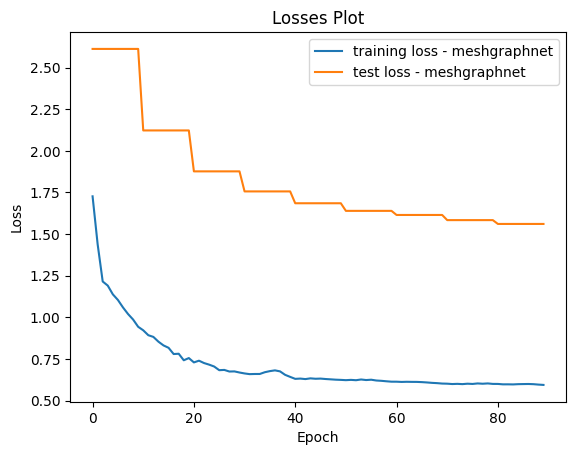

In [44]:
import pandas as pd
df = pd.read_csv("/content/gdrive/My Drive/Groupe4/best_models/model_nl20_bs1_hd10_ep99_wd0.0005_lr0.001_shuff_True_tr3_te2.csv")
#print(losses)

save_plots(args,df["train_loss"], df["test_loss"], df["test_loss"])

In [49]:
data_list[0].x[:,:3]

tensor([[ 3.6499e-14, -3.2506e-14, -4.2059e-15],
        [ 4.4503e-16, -8.5296e-16,  6.4861e-17],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        ...,
        [ 5.8499e+01, -4.1504e+01, -2.5903e+01],
        [ 3.0462e+02, -2.1420e+02, -1.3215e+01],
        [ 3.6148e+02, -1.6169e+02, -1.3307e+01]])

In [51]:
data_list[0].y

tensor([[-6.2323e-14,  5.4279e-14,  1.6210e-15],
        [-5.4267e-16,  1.1093e-15, -1.7142e-16],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        ...,
        [-1.2101e+02,  9.1078e+01,  7.6630e+01],
        [-2.9521e+02,  1.9721e+02, -6.6920e+01],
        [-4.7249e+02,  1.1157e+02, -3.6285e+01]])

In [54]:
def loss (pred, label):
  return torch.mean((pred-label)**2)/len(pred)
loss(data_list[0].x[:,:3],data_list[0].y)

tensor(6.9251)